# Customer Churn Prediction


In [62]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, f1_score, classification_report, roc_auc_score ,confusion_matrix ,roc_curve
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import seaborn as sns




# Load and preprocess data

In [63]:
df = pd.read_csv('../bank-customer-churn-prediction-challenge/train.csv')
num_cols = df.select_dtypes(include=['int64', 'float64']).columns
cat_cols = df.select_dtypes(include=['object', 'category']).columns

# Plot histograms

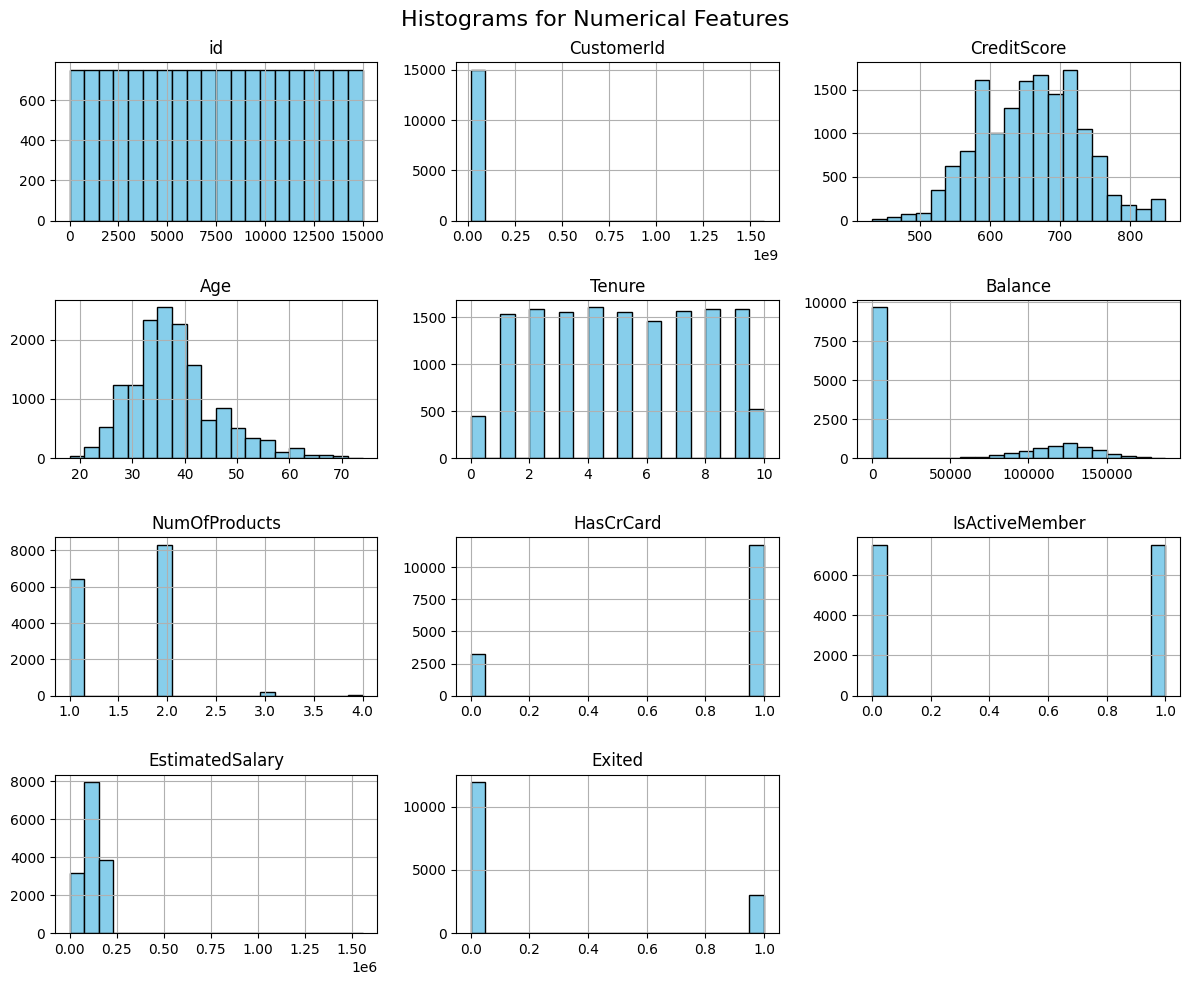

In [64]:
df[num_cols].hist(figsize=(12, 10), bins=20, color='skyblue', edgecolor='black')
plt.suptitle('Histograms for Numerical Features', fontsize=16)
plt.tight_layout()
plt.show()

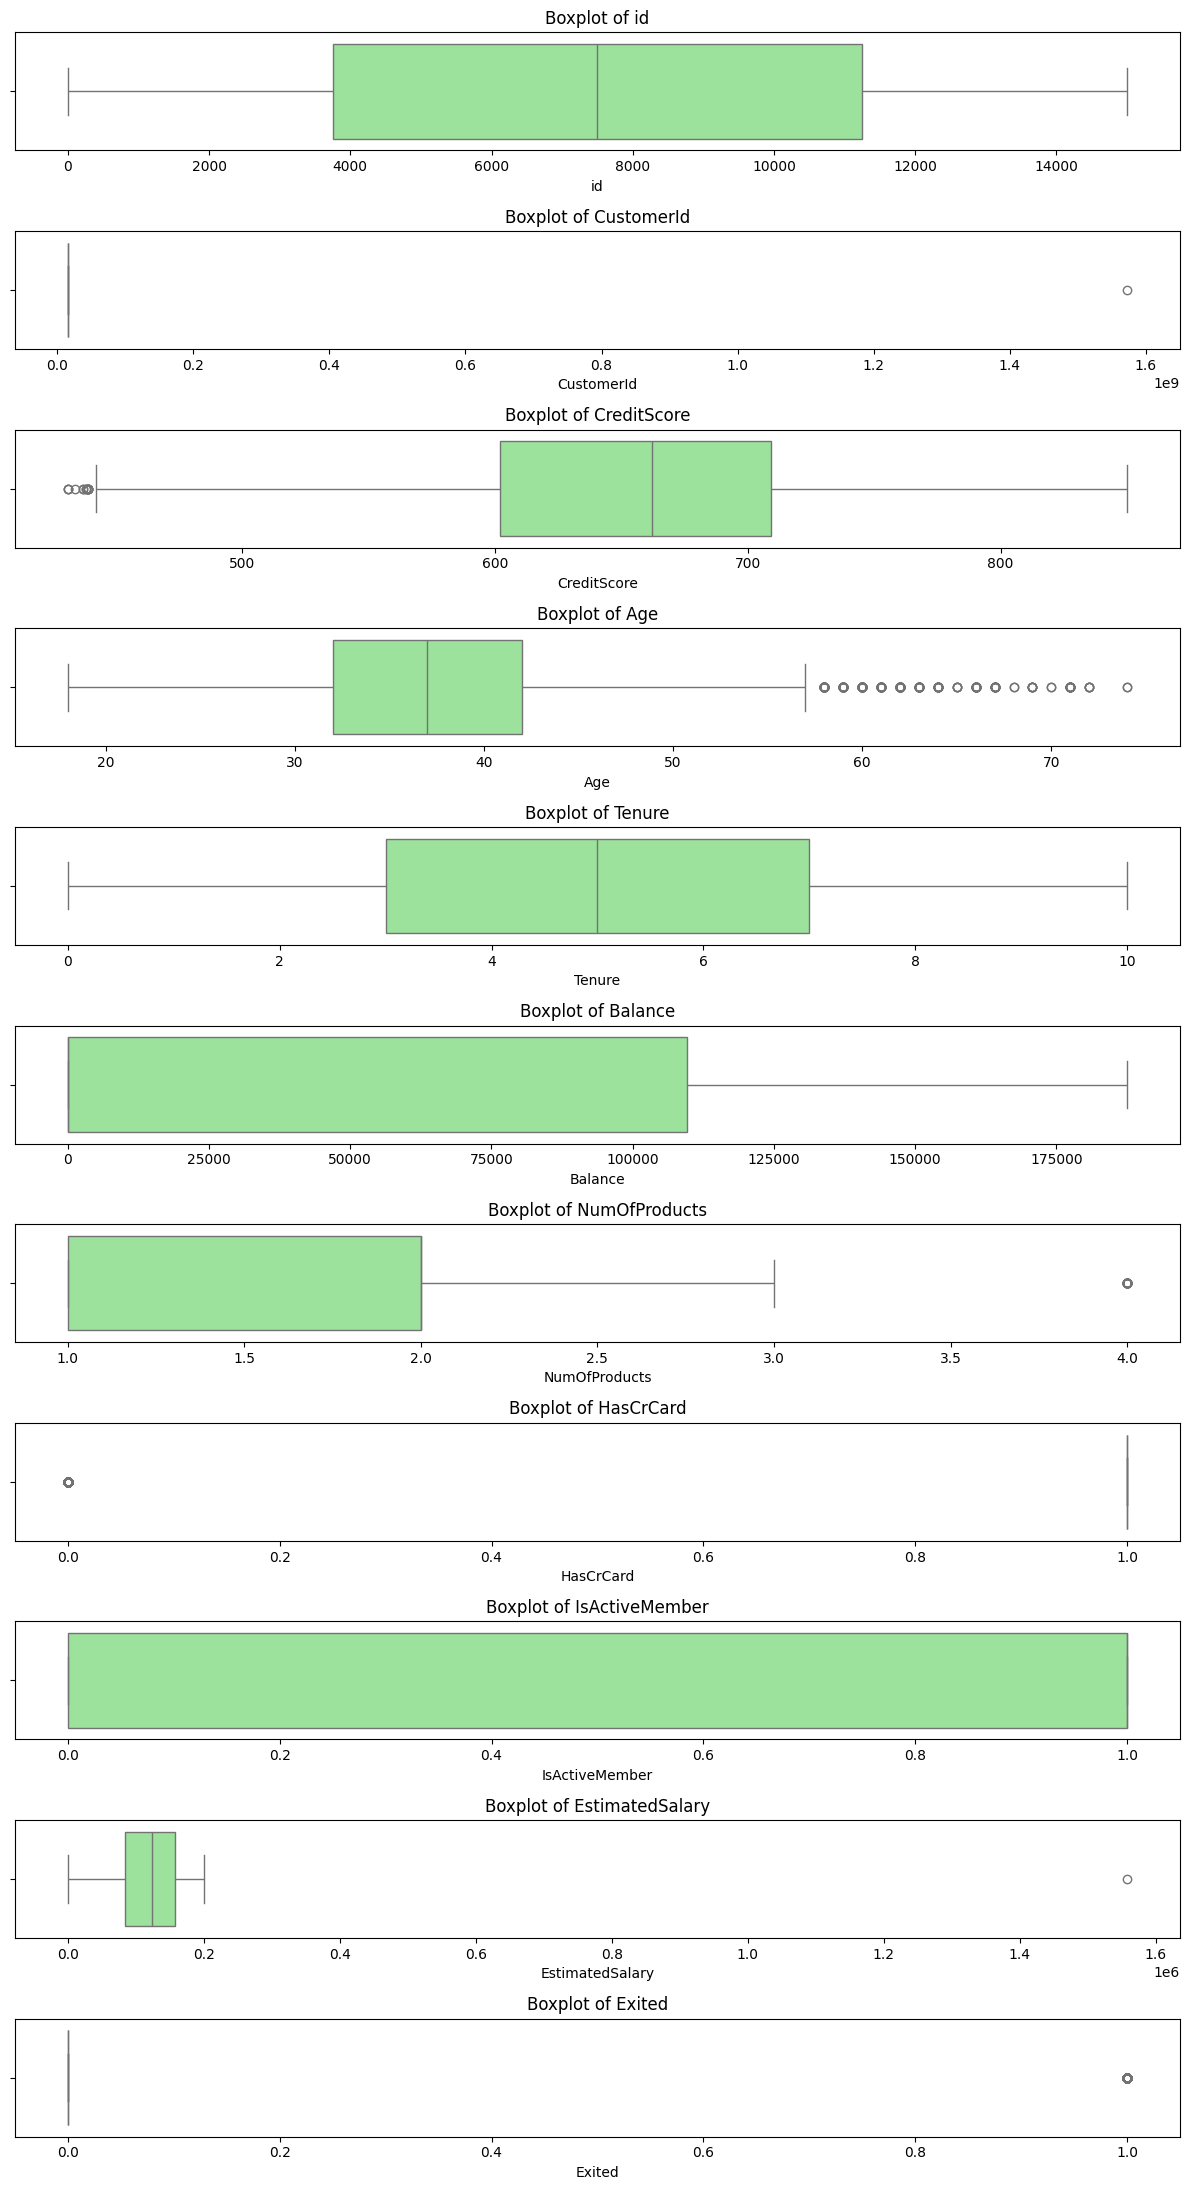

In [65]:
plt.figure(figsize=(12, len(num_cols) * 2))
for i, col in enumerate(num_cols, 1):
    plt.subplot(len(num_cols), 1, i)
    sns.boxplot(x=df[col], color='lightgreen')
    plt.title(f'Boxplot of {col}', fontsize=12)
plt.tight_layout()
plt.show()

# Select categorical columns


/var/folders/3f/cmqbblwj3zx5xm6h9mtrm9j80000gn/T/ipykernel_32606/1785039296.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=col, order=df[col].value_counts().index, palette="viridis")
/var/folders/3f/cmqbblwj3zx5xm6h9mtrm9j80000gn/T/ipykernel_32606/1785039296.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=col, order=df[col].value_counts().index, palette="viridis")


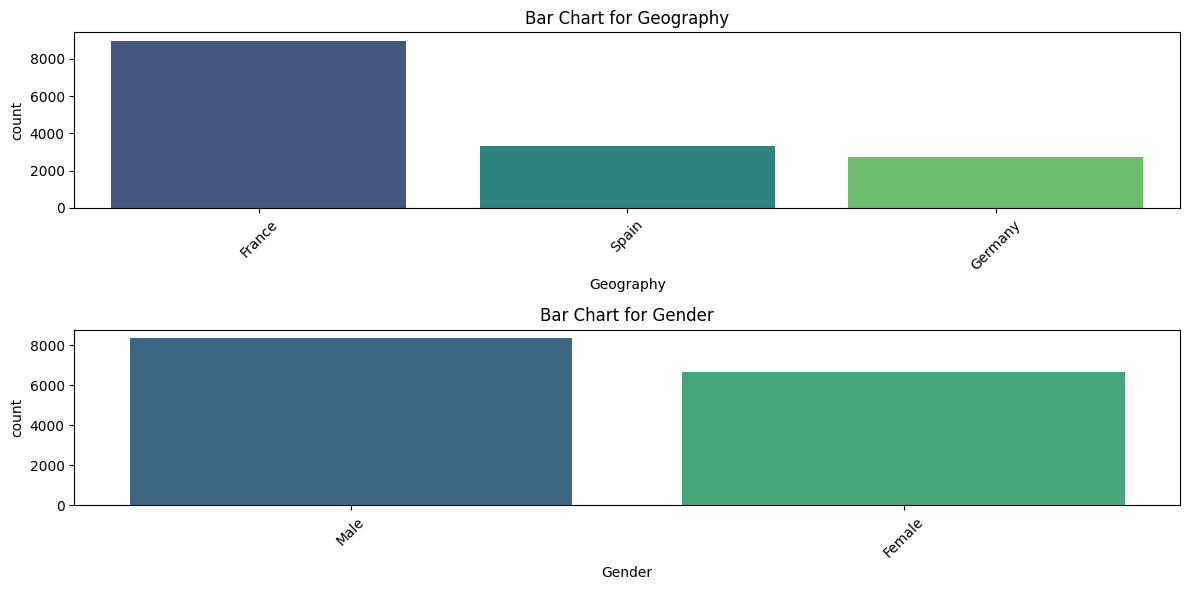

In [66]:
cat_cols = df.select_dtypes(include=['object', 'category']).columns
cat_cols = [col for col in cat_cols if col != 'Surname']

plt.figure(figsize=(12, len(cat_cols) * 3))
for i, col in enumerate(cat_cols, 1):
    plt.subplot(len(cat_cols), 1, i)
    sns.countplot(data=df, x=col, order=df[col].value_counts().index, palette="viridis")
    plt.title(f'Bar Chart for {col}', fontsize=12)
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Load and preprocess data


In [67]:
df.drop([ 'CustomerId', 'Surname'], axis=1, inplace=True)
df = pd.get_dummies(df, columns=['Geography', 'Gender'], drop_first=True)

# Split features and target


In [68]:
X = df.drop('Exited', axis=1)
y = df['Exited']

# Add target column temporarily


In [70]:
df_corr = df.copy()
df_corr["Exited"] = y

# Heatmap of correlations


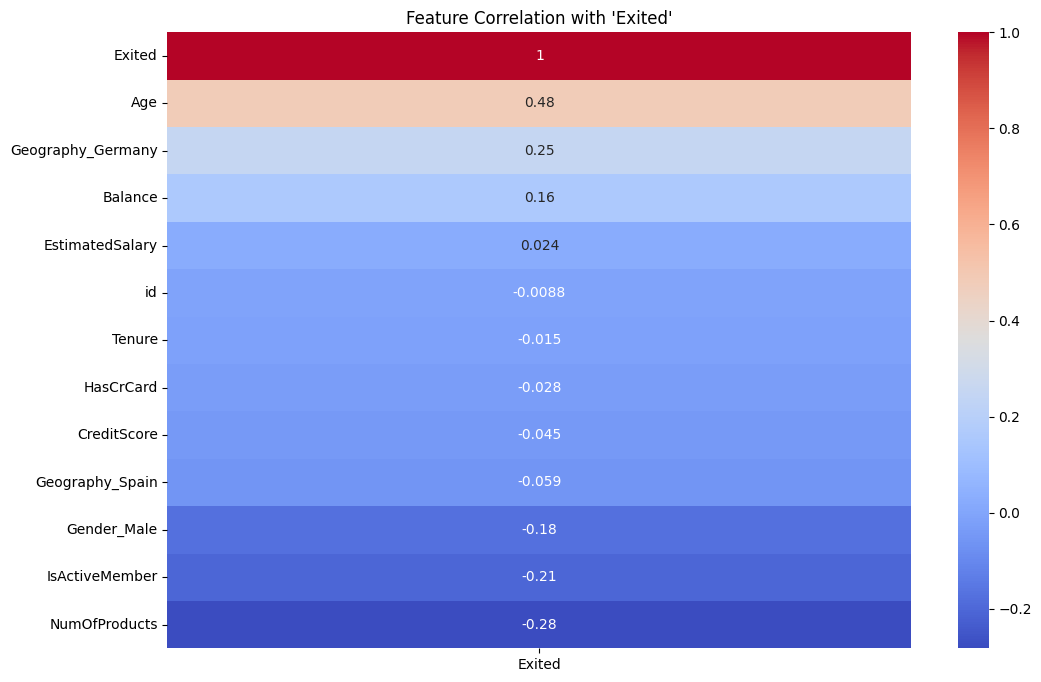

In [71]:
corr_matrix = df_corr.corr(numeric_only=True)

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix[['Exited']].sort_values('Exited', ascending=False), annot=True, cmap='coolwarm')
plt.title("Feature Correlation with 'Exited'")
plt.show()

# Distribution of target variable


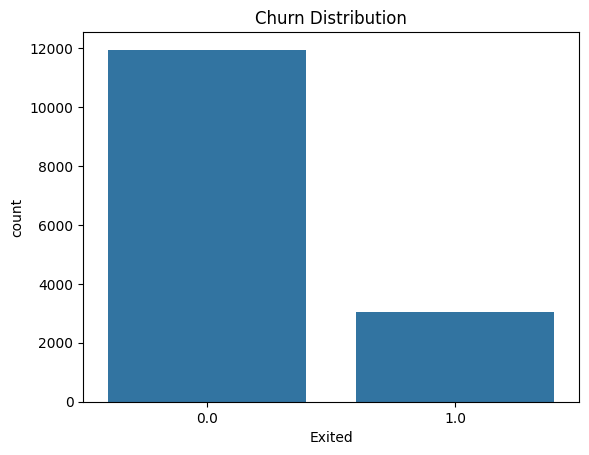

In [72]:
sns.countplot(x='Exited', data=df)
plt.title('Churn Distribution')
plt.show()

# Age distribution by churn


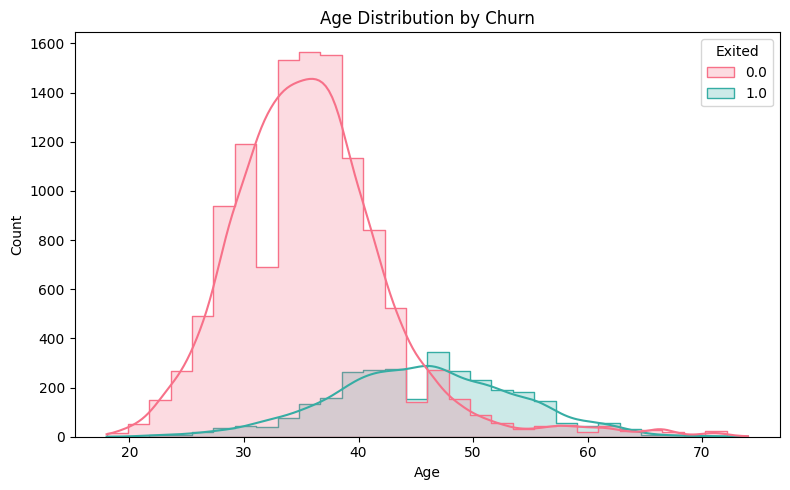

In [73]:
plt.figure(figsize=(8, 5))
sns.histplot(data=df, x='Age', hue='Exited', kde=True, bins=30, palette="husl", element="step")
plt.title("Age Distribution by Churn")
plt.xlabel("Age")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# Prepare training set


In [74]:
corr_target = df.corr(numeric_only=True)['Exited'].abs()
selected_features = corr_target[corr_target > 0.05].index.tolist()
selected_features.remove('Exited') 
X_filtered = df[selected_features]

# Handle missing values


In [75]:
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X_filtered)

# Scale features


In [76]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# Train-test split


In [77]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


In [78]:
def preprocess(df):
    df = df.copy()
    for col in ['id', 'CustomerId', 'Surname']:
        if col in df.columns:
            df.drop(col, axis=1, inplace=True)
    df = pd.get_dummies(df, columns=['Geography', 'Gender'], drop_first=True)
    return df

# Build neural network model


In [79]:
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto']
}

grid = GridSearchCV(SVC(probability=True, random_state=42), param_grid,
                    scoring='f1', cv=2, verbose=1, n_jobs=-1)
grid.fit(X_train, y_train)

print("Best Params:", grid.best_params_)
model = grid.best_estimator_


Fitting 2 folds for each of 18 candidates, totalling 36 fits
Best Params: {'C': 10, 'gamma': 'scale', 'kernel': 'poly'}


# Train model


In [80]:
history = model.fit(X_train, y_train)
joblib.dump(model, '../models/model_svc.pkl')
joblib.dump(imputer, "../imputer/imputer.pkl")
joblib.dump(scaler, "../scaler/scaler.pkl")
joblib.dump(X_filtered.columns, "../feature_columns/feature_columns.pkl")

print("Logistic model and preprocessors saved.")
print("Model saved as model_neural_network.pkl")


Logistic model and preprocessors saved.
Model saved as model_neural_network.pkl


# Evaluate model


In [81]:
y_pred_proba = model.predict(X_test).flatten()
y_pred = (y_pred_proba > 0.5).astype(int)

acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f'Accuracy: {acc:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'ROC AUC: {roc_auc:.4f}')
print(classification_report(y_test, y_pred))

Accuracy: 0.9057
F1 Score: 0.7271
ROC AUC: 0.8060
              precision    recall  f1-score   support

         0.0       0.92      0.97      0.94      2413
         1.0       0.84      0.64      0.73       587

    accuracy                           0.91      3000
   macro avg       0.88      0.81      0.84      3000
weighted avg       0.90      0.91      0.90      3000



# Confusion Matrix


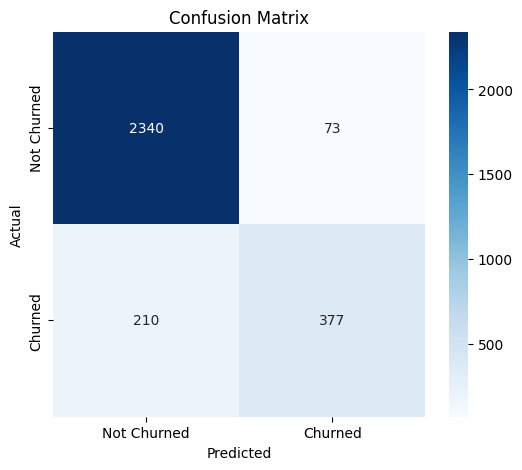

In [82]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Churned", "Churned"], yticklabels=["Not Churned", "Churned"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# ROC Curve

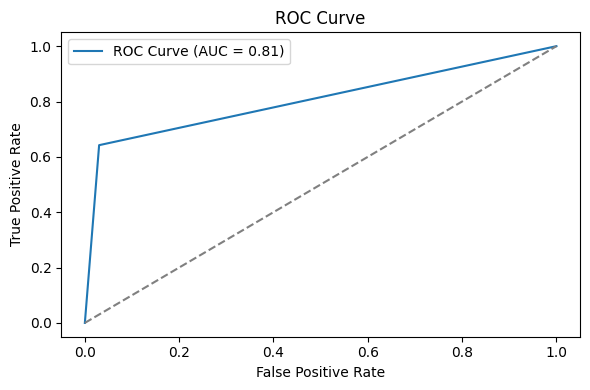

In [83]:
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.tight_layout()
plt.show()

# Accuracy


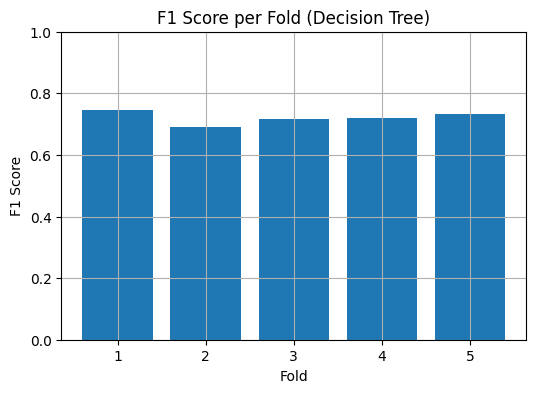

In [84]:
scores = cross_val_score(model, X_scaled, y, cv=5, scoring='f1')

plt.figure(figsize=(6, 4))
plt.bar(range(1, 6), scores)
plt.title("F1 Score per Fold (Decision Tree)")
plt.xlabel("Fold")
plt.ylabel("F1 Score")
plt.ylim(0, 1)
plt.grid(True)
plt.show()

# Load Test Data

In [85]:
test_df = pd.read_csv("../bank-customer-churn-prediction-challenge/test.csv")


# Preprocess


In [86]:
X_test_raw = preprocess(test_df)


# Align columns with training set


In [87]:
feature_columns = joblib.load("../feature_columns/feature_columns.pkl")
X_test_raw = X_test_raw.reindex(columns=feature_columns, fill_value=0)

# Apply imputer and scaler


In [88]:
imputer = joblib.load("../imputer/imputer.pkl")
scaler = joblib.load("../scaler/scaler.pkl")
X_test_imputed = imputer.transform(X_test_raw)
X_test_scaled = scaler.transform(X_test_imputed)

# Load model and predict probabilities


In [89]:
model = joblib.load("../models/model_svc.pkl")
probas = model.predict(X_test_scaled).flatten()

# Build submission


In [90]:
submission = pd.DataFrame({
    'id': test_df['id'] if 'id' in test_df.columns else test_df['CustomerId'],
    'Exited': probas
})
submission.to_csv("../submissions/submission_svc.csv", index=False)

# Write Scores to CSV

In [91]:
score_df = pd.DataFrame({
    "Metric": ["Accuracy", "F1 Score", "ROC AUC"],
    "Score": [acc, f1, roc_auc]
})
score_df.to_csv("../scores/model_scores_svc.csv", index=False)